<a href="https://colab.research.google.com/github/kthanikonda/Privacy-Aware-Computing/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
! pip install textstat

In [65]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from transformers import pipeline
import textstat
from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [66]:
# Download necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# Initialize sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Initialize semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [67]:
# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

In [68]:
# Step 2: DP-Based Text Sanitization Functions
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            modified_text = modified_text.replace(ent.text, "The Company")
            entity_replacements.append((ent.text, "The Company"))
        elif ent.label_ == "GPE":
            modified_text = modified_text.replace(ent.text, "The Location")
            entity_replacements.append((ent.text, "The Location"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

In [69]:
def get_filtered_similar_words(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

In [70]:
def dp_word_substitute(text, epsilon=1.0, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []

    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue

        candidates = get_filtered_similar_words(word, k, similarity_threshold)
        if len(candidates) > 1:
            # Implement Exponential Mechanism (Instead of selecting the most similar word)
            scores = np.array([word_vectors.similarity(word, w) for w in candidates])
            probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))

            replacement = np.random.choice(candidates, p=probabilities)
            if replacement != word:
                word_changes.append((word, replacement))
            new_words.append(replacement)
        else:
            new_words.append(word)

    return " ".join(new_words), word_changes

In [71]:
def shuffle_sentences(text, epsilon=0.5):
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    sentence_changes = list(zip(sentences, shuffled_sentences))
    return " ".join(shuffled_sentences), sentence_changes

In [72]:
# Add Controlled Laplace Noise
def add_laplace_noise(text, epsilon=0.5):
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r"\b\d+\b", replace_number, text)
    return modified_text

In [73]:
# Sentiment Analysis
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    avg_sentiment = np.mean(sentiment_scores)
    return avg_sentiment

In [74]:
# Deception Score Calculation
def calculate_deception_score(text):
    clarity_score = textstat.flesch_reading_ease(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally", "typically", "occasionally", "some"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (100 - clarity_score) * 0.7 + (vague_word_count * 5) * 0.3
    return clarity_score, deception_score

In [75]:
# Privacy Leakage Analysis
def calculate_privacy_leakage(original_text, sanitized_text):
    similarity_score = util.pytorch_cos_sim(
        semantic_model.encode(original_text, convert_to_tensor=True),
        semantic_model.encode(sanitized_text, convert_to_tensor=True)
    ).item()
    return similarity_score

In [76]:
# Apply Improved DP-Based Transformations with Enhanced Clarity
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized, google_word_changes = dp_word_substitute(google_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
google_sanitized, google_sentence_changes = shuffle_sentences(google_sanitized, epsilon=0.5)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute(linkedin_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
linkedin_sanitized, linkedin_sentence_changes = shuffle_sentences(linkedin_sanitized, epsilon=0.5)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)


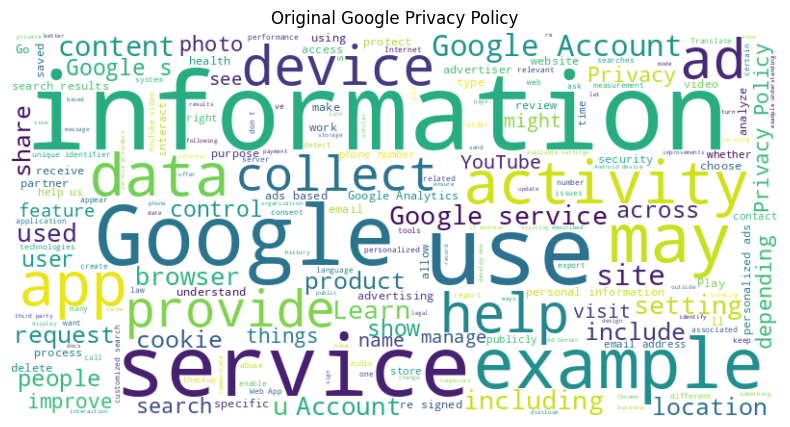

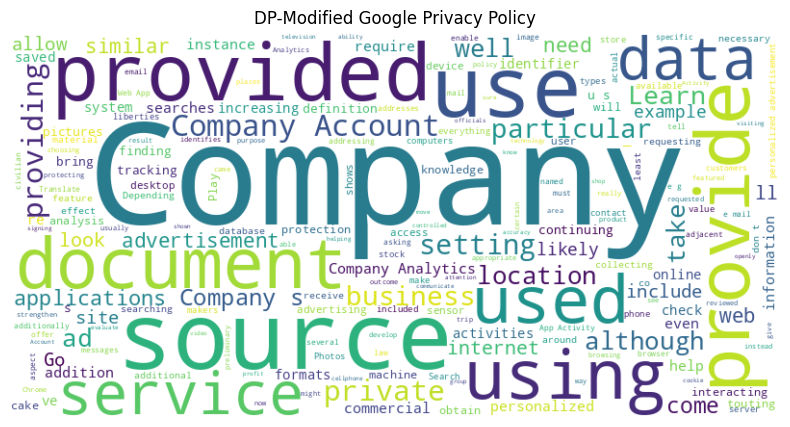

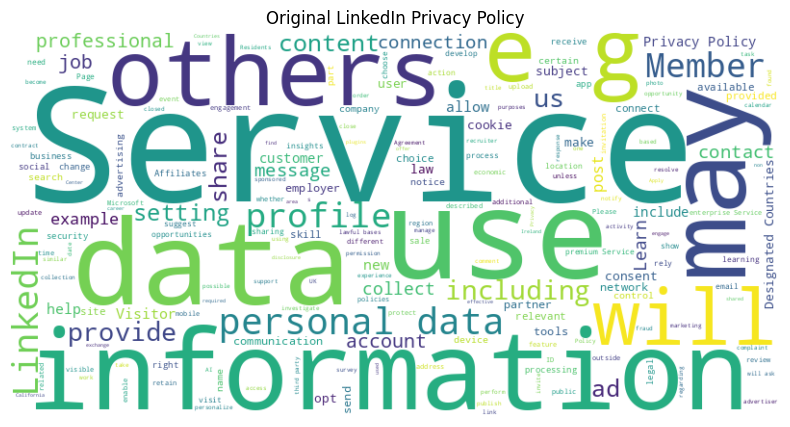

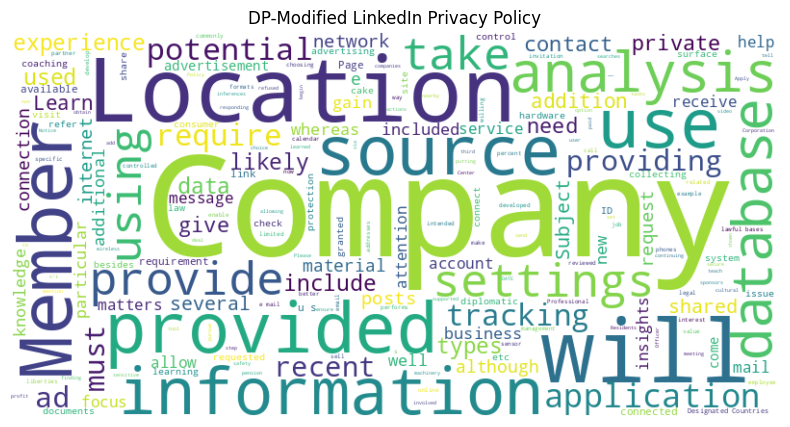

In [77]:
# Word Cloud Visualization
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate Word Clouds for Original and Sanitized Texts
generate_wordcloud(google_text, "Original Google Privacy Policy")
generate_wordcloud(google_sanitized, "DP-Modified Google Privacy Policy")

generate_wordcloud(linkedin_text, "Original LinkedIn Privacy Policy")
generate_wordcloud(linkedin_sanitized, "DP-Modified LinkedIn Privacy Policy")


In [78]:
# Collect Scores for Visualization
scores_data = []

for name, original_text, sanitized_text in [
    ("Google", google_text, google_sanitized),
    ("LinkedIn", linkedin_text, linkedin_sanitized)
]:
    original_clarity, original_deception = calculate_deception_score(original_text)
    sanitized_clarity, sanitized_deception = calculate_deception_score(sanitized_text)

    original_sentiment = calculate_sentiment(original_text)
    sanitized_sentiment = calculate_sentiment(sanitized_text)

    privacy_leakage_score = calculate_privacy_leakage(original_text, sanitized_text)

    scores_data.append({
        "Policy": name,
        "Original Clarity": original_clarity,
        "Sanitized Clarity": sanitized_clarity,
        "Original Deception": original_deception,
        "Sanitized Deception": sanitized_deception,
        "Original Sentiment": original_sentiment,
        "Sanitized Sentiment": sanitized_sentiment,
        "Privacy Leakage": privacy_leakage_score
    })

# Create DataFrame for Visualization
scores_df = pd.DataFrame(scores_data)
print(scores_df)

     Policy  Original Clarity  Sanitized Clarity  Original Deception  \
0    Google             40.18               9.63             241.374   
1  LinkedIn             40.08              13.48             145.444   

   Sanitized Deception  Original Sentiment  Sanitized Sentiment  \
0              145.759            0.927001             0.951802   
1              101.064            0.924182             0.938945   

   Privacy Leakage  
0         0.545901  
1         0.320741  


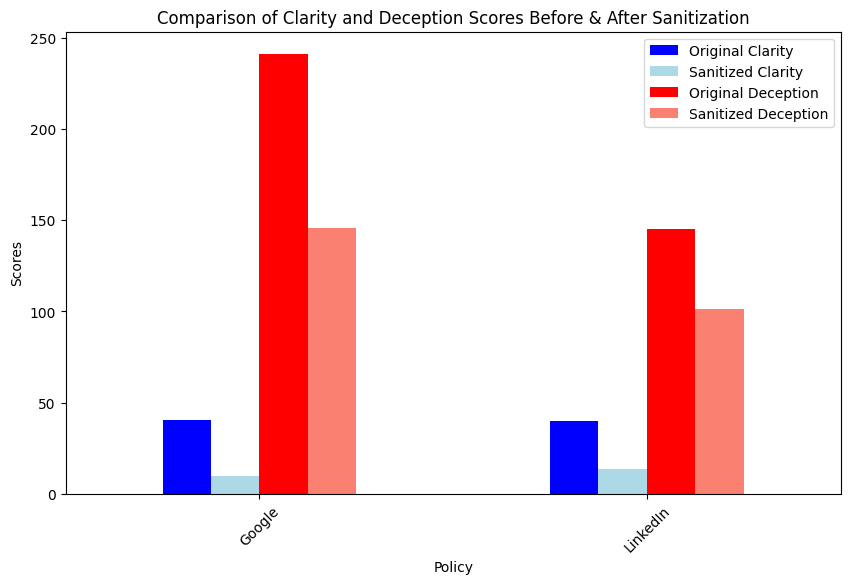

In [79]:
# Visualization: Clarity and Deception Scores
scores_df.set_index("Policy")[[
    "Original Clarity", "Sanitized Clarity",
    "Original Deception", "Sanitized Deception"
]].plot(kind='bar', figsize=(10, 6), color=['blue', 'lightblue', 'red', 'salmon'])
plt.ylabel("Scores")
plt.title("Comparison of Clarity and Deception Scores Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

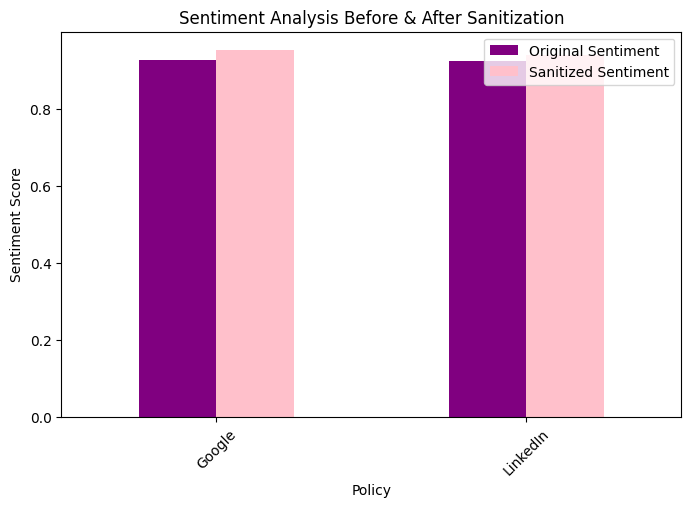

In [80]:
# Visualization: Sentiment Analysis
scores_df.set_index("Policy")[[
    "Original Sentiment", "Sanitized Sentiment"
]].plot(kind='bar', figsize=(8, 5), color=['purple', 'pink'])
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

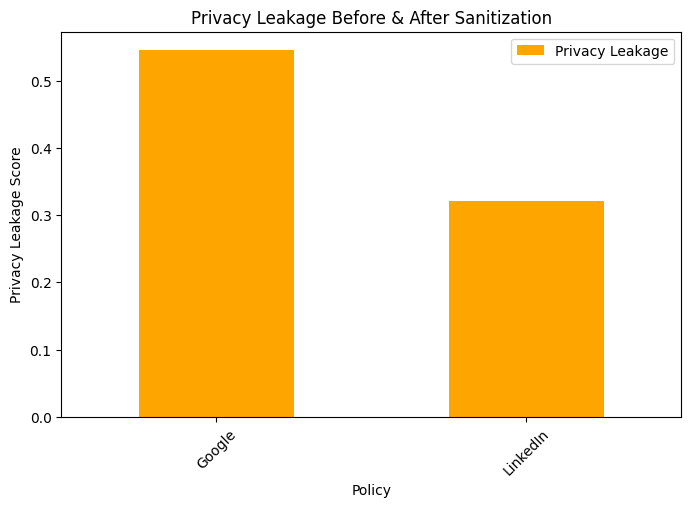

In [81]:
# Visualization: Privacy Leakage Analysis
scores_df.set_index("Policy")[["Privacy Leakage"]].plot(kind='bar', figsize=(8, 5), color='orange')
plt.ylabel("Privacy Leakage Score")
plt.title("Privacy Leakage Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

In [82]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from transformers import pipeline
import textstat
from sentence_transformers import SentenceTransformer, util
import pandas as pd

In [83]:
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# Initialize sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Initialize semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [84]:
# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)


In [85]:
# Step 2: DP-Based Text Sanitization Functions
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            modified_text = modified_text.replace(ent.text, "The Company")
            entity_replacements.append((ent.text, "The Company"))
        elif ent.label_ == "GPE":
            modified_text = modified_text.replace(ent.text, "The Location")
            entity_replacements.append((ent.text, "The Location"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements



In [86]:
def get_filtered_similar_words(word, k=5, similarity_threshold=0.75):
    try:
        similar_words = word_vectors.most_similar(word, topn=k)
        filtered_words = [w[0] for w in similar_words if w[1] >= similarity_threshold]
        return filtered_words if filtered_words else [word]
    except KeyError:
        return [word]

In [87]:
def dp_word_substitute(text, epsilon=0.5, k=5, similarity_threshold=0.75):
    words = word_tokenize(text)
    new_words = []
    word_changes = []

    for word in words:
        if word.lower() in stopwords:
            new_words.append(word)
            continue

        candidates = get_filtered_similar_words(word, k, similarity_threshold)
        if len(candidates) > 1:
            # Implement Exponential Mechanism with improved word selection
            scores = np.array([word_vectors.similarity(word, w) for w in candidates])
            probabilities = np.exp(epsilon * scores) / np.sum(np.exp(epsilon * scores))

            replacement = np.random.choice(candidates, p=probabilities)
            if replacement != word:
                word_changes.append((word, replacement))
            new_words.append(replacement)
        else:
            new_words.append(word)

    return " ".join(new_words), word_changes

In [88]:
def shuffle_sentences(text, epsilon=0.3):  # Reduced epsilon to limit excessive shuffling
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    sentence_changes = list(zip(sentences, shuffled_sentences))
    return " ".join(shuffled_sentences), sentence_changes

In [89]:
# Add Controlled Laplace Noise with Reduced Impact
def add_laplace_noise(text, epsilon=0.2):  # Reduced Laplace noise for less distortion
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r"\b\d+\b", replace_number, text)
    return modified_text

In [90]:
# Sentiment Analysis
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    avg_sentiment = np.mean(sentiment_scores)
    return avg_sentiment

In [91]:
# Deception Score Calculation
def calculate_deception_score(text):
    clarity_score = textstat.flesch_reading_ease(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally", "typically", "occasionally", "some"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (100 - clarity_score) * 0.7 + (vague_word_count * 5) * 0.3
    return clarity_score, deception_score


In [92]:
# Privacy Leakage Analysis
def calculate_privacy_leakage(original_text, sanitized_text):
    similarity_score = util.pytorch_cos_sim(
        semantic_model.encode(original_text, convert_to_tensor=True),
        semantic_model.encode(sanitized_text, convert_to_tensor=True)
    ).item()
    return similarity_score

In [93]:
# Apply Improved DP-Based Transformations with Enhanced Clarity
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized, google_word_changes = dp_word_substitute(google_sanitized, epsilon=0.5, k=5, similarity_threshold=0.8)
google_sanitized, google_sentence_changes = shuffle_sentences(google_sanitized, epsilon=0.3)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.2)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute(linkedin_sanitized, epsilon=0.5, k=5, similarity_threshold=0.8)
linkedin_sanitized, linkedin_sentence_changes = shuffle_sentences(linkedin_sanitized, epsilon=0.3)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.2)




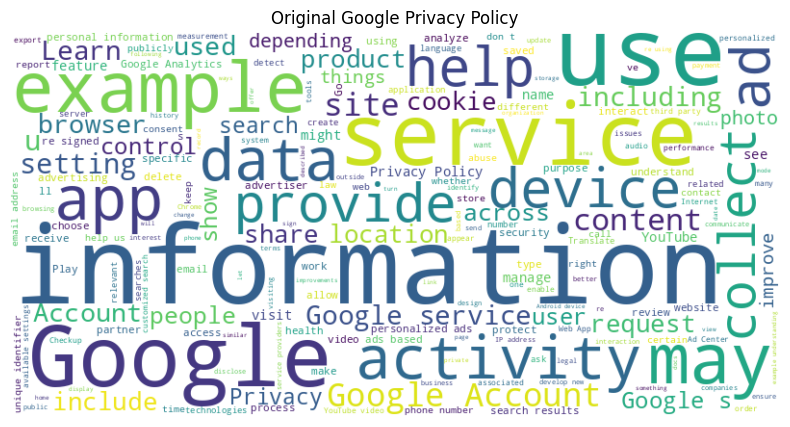

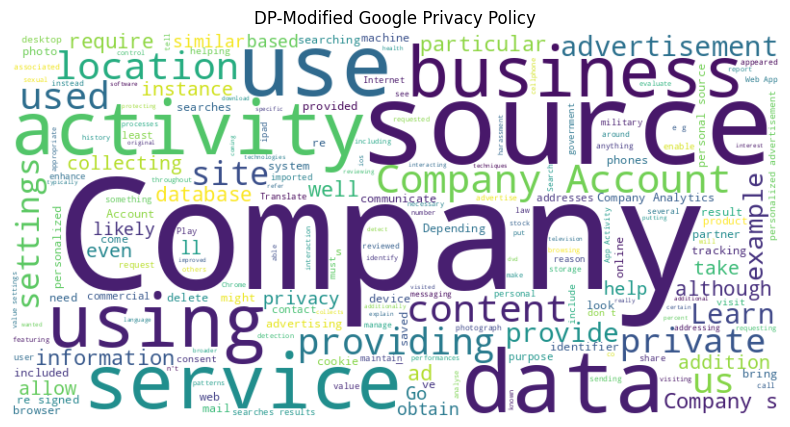

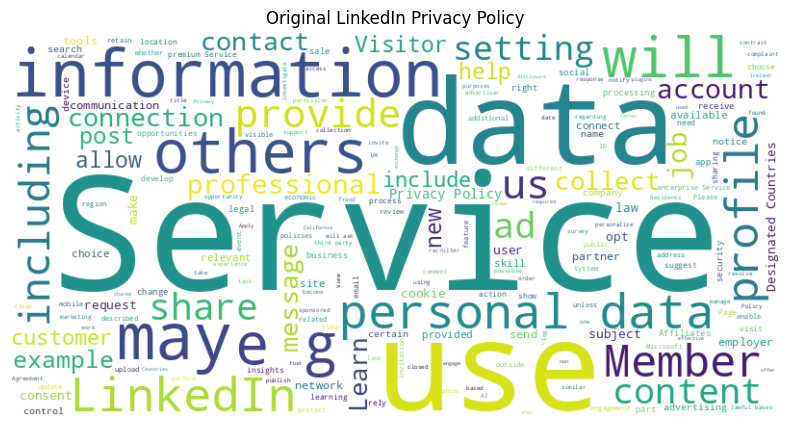

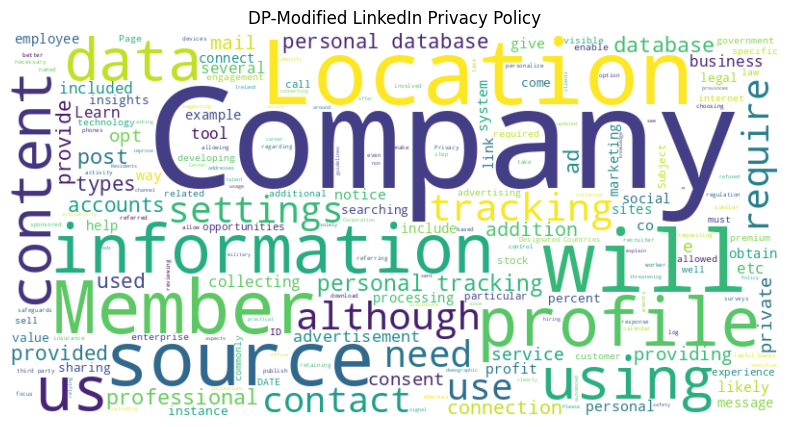

In [94]:
# Word Cloud Visualization
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

    # Generate Word Clouds for Original and Sanitized Texts
generate_wordcloud(google_text, "Original Google Privacy Policy")
generate_wordcloud(google_sanitized, "DP-Modified Google Privacy Policy")

generate_wordcloud(linkedin_text, "Original LinkedIn Privacy Policy")
generate_wordcloud(linkedin_sanitized, "DP-Modified LinkedIn Privacy Policy")

In [95]:
# Collect Scores for Visualization
scores_data = []

for name, original_text, sanitized_text in [
    ("Google", google_text, google_sanitized),
    ("LinkedIn", linkedin_text, linkedin_sanitized)
]:
    original_clarity, original_deception = calculate_deception_score(original_text)
    sanitized_clarity, sanitized_deception = calculate_deception_score(sanitized_text)

    original_sentiment = calculate_sentiment(original_text)
    sanitized_sentiment = calculate_sentiment(sanitized_text)

    privacy_leakage_score = calculate_privacy_leakage(original_text, sanitized_text)

    scores_data.append({
        "Policy": name,
        "Original Clarity": original_clarity,
        "Sanitized Clarity": sanitized_clarity,
        "Original Deception": original_deception,
        "Sanitized Deception": sanitized_deception,
        "Original Sentiment": original_sentiment,
        "Sanitized Sentiment": sanitized_sentiment,
        "Privacy Leakage": privacy_leakage_score
    })

# Create DataFrame for Visualization
scores_df = pd.DataFrame(scores_data)
print(scores_df)


     Policy  Original Clarity  Sanitized Clarity  Original Deception  \
0    Google             40.18               2.52             241.374   
1  LinkedIn             40.08               6.58             145.444   

   Sanitized Deception  Original Sentiment  Sanitized Sentiment  \
0              161.236            0.927001             0.973715   
1              105.894            0.924182             0.937220   

   Privacy Leakage  
0         0.575820  
1         0.401327  


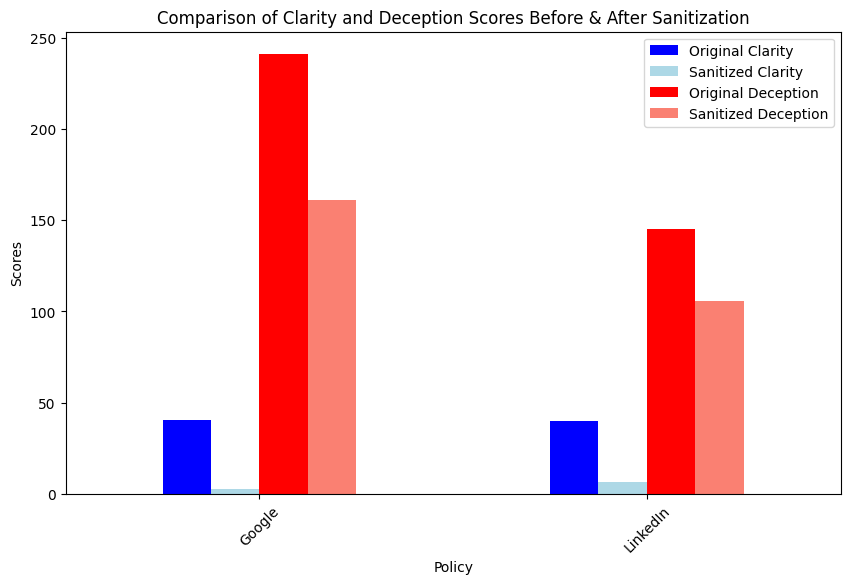

In [96]:
# Visualization: Clarity and Deception Scores
scores_df.set_index("Policy")[[
    "Original Clarity", "Sanitized Clarity",
    "Original Deception", "Sanitized Deception"
]].plot(kind='bar', figsize=(10, 6), color=['blue', 'lightblue', 'red', 'salmon'])
plt.ylabel("Scores")
plt.title("Comparison of Clarity and Deception Scores Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

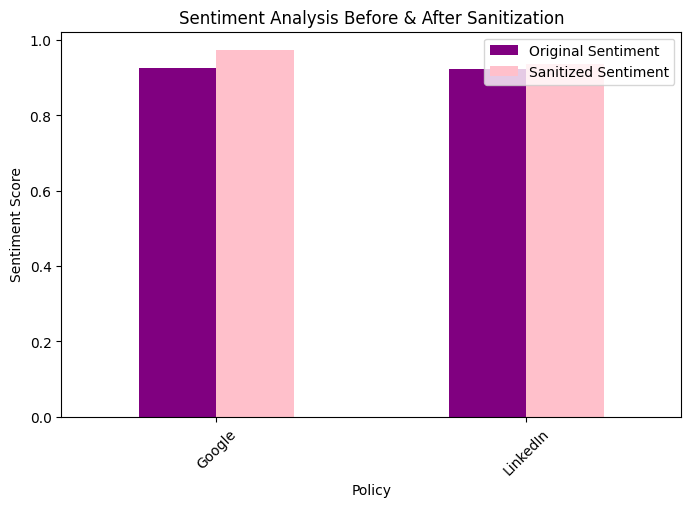

In [97]:
# Visualization: Sentiment Analysis
scores_df.set_index("Policy")[["Original Sentiment", "Sanitized Sentiment"]].plot(kind='bar', figsize=(8, 5), color=['purple', 'pink'])
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

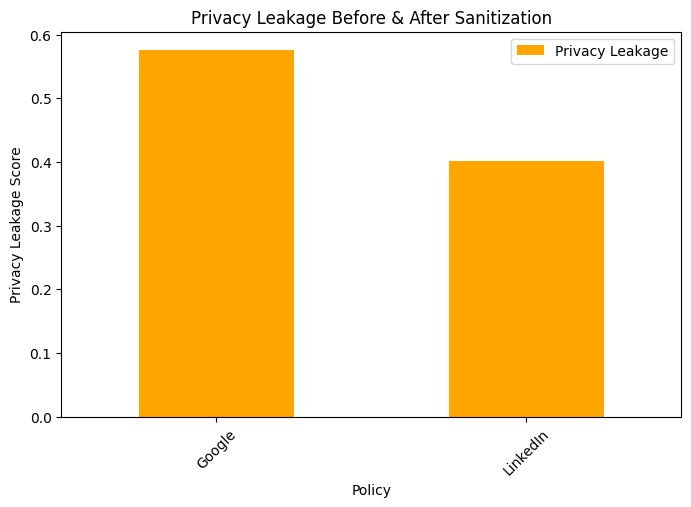

In [98]:
# Visualization: Privacy Leakage Analysis
scores_df.set_index("Policy")[["Privacy Leakage"]].plot(kind='bar', figsize=(8, 5), color='orange')
plt.ylabel("Privacy Leakage Score")
plt.title("Privacy Leakage Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

In [24]:
import requests
import re
import numpy as np
import nltk
import spacy
import gensim.downloader as api
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from transformers import pipeline
import textstat
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from nltk.corpus import wordnet


In [25]:
# Download necessary resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")  # Load spaCy model for Named Entity Recognition (NER)
stopwords = set(nltk.corpus.stopwords.words("english"))  # Load stopwords

# Load Word2Vec Model for Semantic Similarity
word_vectors = api.load("glove-wiki-gigaword-50")  # Use GloVe embeddings

# Initialize sentiment analysis model
sentiment_analyzer = pipeline("sentiment-analysis")

# Initialize semantic similarity model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [26]:
# Step 1: Extract Privacy Policies
def extract_privacy_policy(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    paragraphs = soup.find_all("p")
    policy_text = " ".join([p.get_text() for p in paragraphs])
    return policy_text if policy_text else "Privacy Policy text not found."

# URLs for Google and LinkedIn Privacy Policies
google_privacy_policy_url = "https://policies.google.com/privacy"
linkedin_privacy_policy_url = "https://www.linkedin.com/legal/privacy-policy"

# Fetch policies
google_text = extract_privacy_policy(google_privacy_policy_url)
linkedin_text = extract_privacy_policy(linkedin_privacy_policy_url)

In [27]:
# Step 2: DP-Based Text Sanitization Functions
def replace_named_entities(text):
    doc = nlp(text)
    modified_text = text
    entity_replacements = []
    for ent in doc.ents:
        if ent.label_ == "ORG":
            modified_text = modified_text.replace(ent.text, "The Company")
            entity_replacements.append((ent.text, "The Company"))
        elif ent.label_ == "GPE":
            modified_text = modified_text.replace(ent.text, "The Location")
            entity_replacements.append((ent.text, "The Location"))
        elif ent.label_ in ["DATE", "TIME", "DURATION"]:
            modified_text = modified_text.replace(ent.text, "<DATE>")
            entity_replacements.append((ent.text, "<DATE>"))
    return modified_text, entity_replacements

In [28]:
# Function to get similarity between two words using GloVe embeddings
def get_similarity(word1, word2):
    try:
        # Get the vector representation of the words
        vector1 = word_vectors[word1]
        vector2 = word_vectors[word2]

        # Calculate and return the cosine similarity
        similarity = 1 - cosine(vector1, vector2)
        return similarity
    except KeyError:
        # If one of the words is not in the vocabulary, return a low similarity score
        return 0.0


In [29]:
# Function to get semantically similar candidates
def get_semantic_candidates(word, k=5):
    try:
        # Find the top-k most similar words to the input word
        similar_words = word_vectors.most_similar(word, topn=k)
        # Extract just the words from the results (ignoring the similarity scores)
        candidates = [similar_word[0] for similar_word in similar_words]
        return candidates
    except KeyError:
        # If the word is not in the model's vocabulary, return an empty list
        return []

In [30]:
def dp_word_substitute(text, epsilon, k, similarity_threshold, mode="default"):
    word_changes = []
    words = text.split()  # Assuming splitting by spaces for simplicity

    for word in words:
        # Find semantically similar candidates (this part needs to be implemented)
        candidates = get_semantic_candidates(word, k)  # This function is hypothetical

        # Filter candidates based on similarity threshold
        candidates = [w for w in candidates if get_similarity(word, w) >= similarity_threshold]

        if candidates:  # Only proceed if there are candidates
            if mode == "random":
                probabilities = [get_probability(w) for w in candidates]
                replacement = np.random.choice(candidates, p=probabilities)
            else:
                replacement = candidates[0]  # Default to the first candidate or original word
            if replacement != word:
                word_changes.append((word, replacement))
        else:
            word_changes.append((word, word))  # If no candidates, retain the original word

    # Reconstruct the sanitized text
    sanitized_text = " ".join([change[1] for change in word_changes])
    return sanitized_text, word_changes


In [31]:
def shuffle_sentences(text, epsilon=0.5):
    sentences = sent_tokenize(text)
    noise = np.random.laplace(0, 1/epsilon, len(sentences))
    shuffled_sentences = [x for _, x in sorted(zip(noise, sentences))]
    sentence_changes = list(zip(sentences, shuffled_sentences))
    return " ".join(shuffled_sentences), sentence_changes

In [32]:
# Add Controlled Laplace Noise
def add_laplace_noise(text, epsilon=0.5):
    def replace_number(match):
        number = int(match.group(0))
        noise = np.random.laplace(0, 1/epsilon)
        noisy_number = max(1, int(number + noise))
        return str(noisy_number)
    modified_text = re.sub(r"\b\d+\b", replace_number, text)
    return modified_text

In [33]:
# Sentiment Analysis
def calculate_sentiment(text):
    sentences = sent_tokenize(text)
    sentiment_scores = [sentiment_analyzer(sentence)[0]['score'] for sentence in sentences]
    avg_sentiment = np.mean(sentiment_scores)
    return avg_sentiment

In [34]:
# Deception Score Calculation
def calculate_deception_score(text):
    clarity_score = textstat.flesch_reading_ease(text)
    vague_words = ["may", "might", "could", "possibly", "sometimes", "often", "generally", "typically", "occasionally", "some"]
    vague_word_count = sum(text.lower().count(word) for word in vague_words)
    deception_score = (100 - clarity_score) * 0.7 + (vague_word_count * 5) * 0.3
    return clarity_score, deception_score

In [35]:
# Privacy Leakage Analysis
def calculate_privacy_leakage(original_text, sanitized_text):
    similarity_score = util.pytorch_cos_sim(
        semantic_model.encode(original_text, convert_to_tensor=True),
        semantic_model.encode(sanitized_text, convert_to_tensor=True)
    ).item()
    return similarity_score

In [36]:
# Apply Improved DP-Based Transformations with Enhanced Clarity
google_sanitized, google_entity_changes = replace_named_entities(google_text)
google_sanitized, google_word_changes = dp_word_substitute(google_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
google_sanitized, google_sentence_changes = shuffle_sentences(google_sanitized, epsilon=0.5)
google_sanitized = add_laplace_noise(google_sanitized, epsilon=0.5)

linkedin_sanitized, linkedin_entity_changes = replace_named_entities(linkedin_text)
linkedin_sanitized, linkedin_word_changes = dp_word_substitute(linkedin_sanitized, epsilon=1.0, k=5, similarity_threshold=0.75)
linkedin_sanitized, linkedin_sentence_changes = shuffle_sentences(linkedin_sanitized, epsilon=0.5)
linkedin_sanitized = add_laplace_noise(linkedin_sanitized, epsilon=0.5)

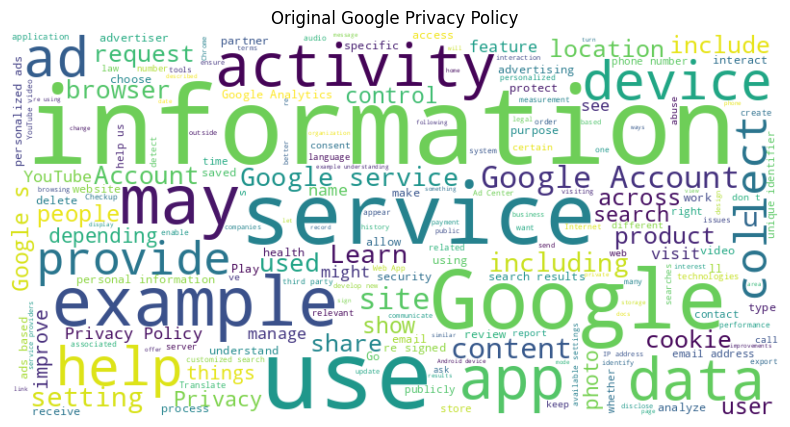

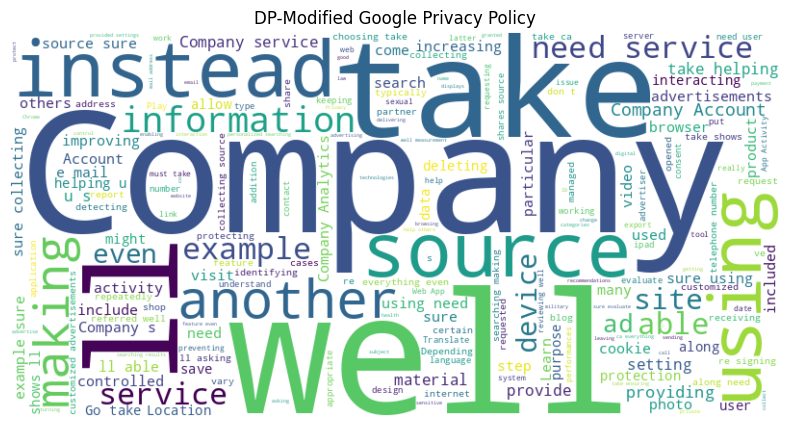

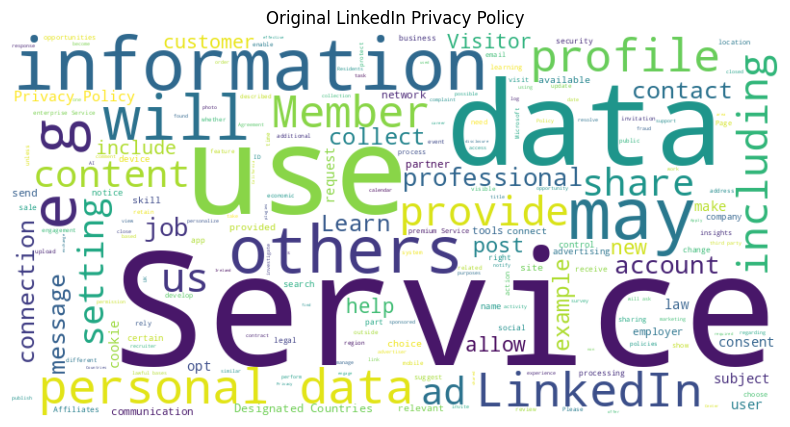

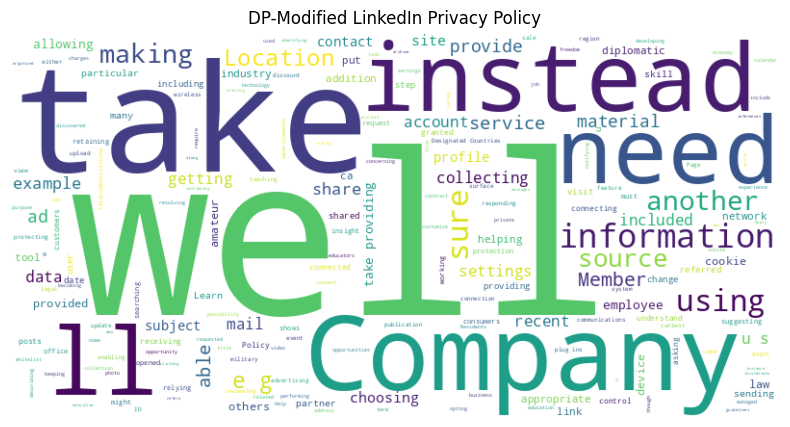

In [37]:
# Word Cloud Visualization
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate Word Clouds for Original and Sanitized Texts
generate_wordcloud(google_text, "Original Google Privacy Policy")
generate_wordcloud(google_sanitized, "DP-Modified Google Privacy Policy")

generate_wordcloud(linkedin_text, "Original LinkedIn Privacy Policy")
generate_wordcloud(linkedin_sanitized, "DP-Modified LinkedIn Privacy Policy")

In [38]:
# Collect Scores for Visualization
scores_data = []

for name, original_text, sanitized_text in [
    ("Google", google_text, google_sanitized),
    ("LinkedIn", linkedin_text, linkedin_sanitized)
]:
    original_clarity, original_deception = calculate_deception_score(original_text)
    sanitized_clarity, sanitized_deception = calculate_deception_score(sanitized_text)

    original_sentiment = calculate_sentiment(original_text)
    sanitized_sentiment = calculate_sentiment(sanitized_text)

    privacy_leakage_score = calculate_privacy_leakage(original_text, sanitized_text)

    scores_data.append({
        "Policy": name,
        "Original Clarity": original_clarity,
        "Sanitized Clarity": sanitized_clarity,
        "Original Deception": original_deception,
        "Sanitized Deception": sanitized_deception,
        "Original Sentiment": original_sentiment,
        "Sanitized Sentiment": sanitized_sentiment,
        "Privacy Leakage": privacy_leakage_score
    })

# Create DataFrame for Visualization
scores_df = pd.DataFrame(scores_data)
print(scores_df)

     Policy  Original Clarity  Sanitized Clarity  Original Deception  \
0    Google             40.18              32.33             241.374   
1  LinkedIn             40.08              32.73             145.444   

   Sanitized Deception  Original Sentiment  Sanitized Sentiment  \
0              158.369            0.927001             0.951407   
1               84.589            0.924182             0.948137   

   Privacy Leakage  
0         0.481421  
1         0.348589  


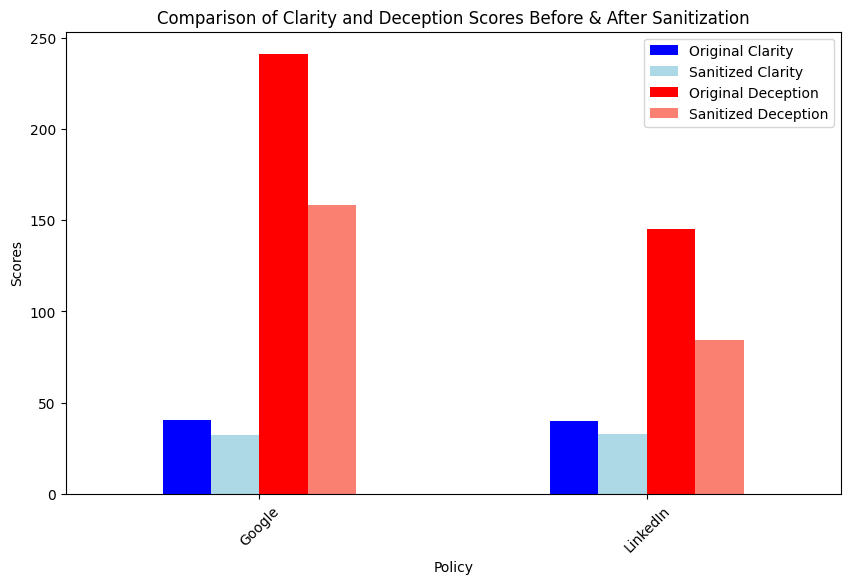

In [39]:
# Visualization: Clarity and Deception Scores
scores_df.set_index("Policy")[[
    "Original Clarity", "Sanitized Clarity",
    "Original Deception", "Sanitized Deception"
]].plot(kind='bar', figsize=(10, 6), color=['blue', 'lightblue', 'red', 'salmon'])
plt.ylabel("Scores")
plt.title("Comparison of Clarity and Deception Scores Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

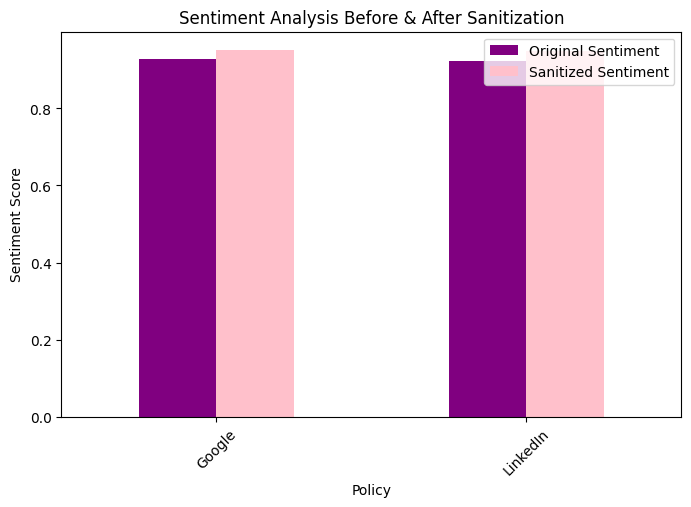

In [40]:
# Visualization: Sentiment Analysis
scores_df.set_index("Policy")[[
    "Original Sentiment", "Sanitized Sentiment"
]].plot(kind='bar', figsize=(8, 5), color=['purple', 'pink'])
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()

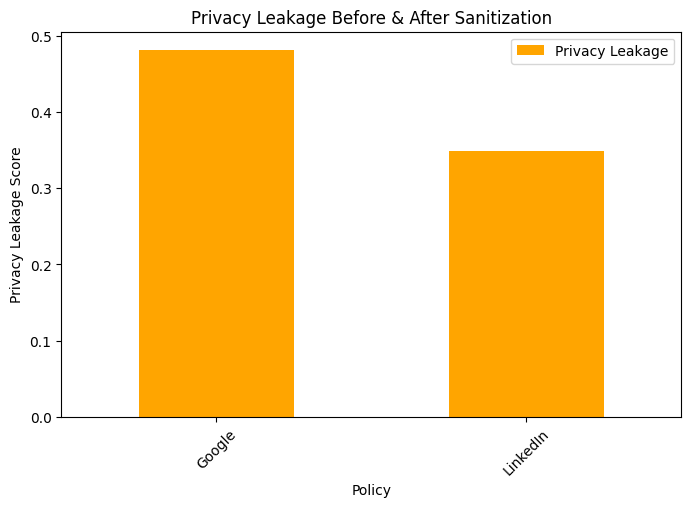

In [41]:
# Visualization: Privacy Leakage Analysis
scores_df.set_index("Policy")[["Privacy Leakage"]].plot(kind='bar', figsize=(8, 5), color='orange')
plt.ylabel("Privacy Leakage Score")
plt.title("Privacy Leakage Before & After Sanitization")
plt.xticks(rotation=45)
plt.show()